# Numerical exercises 08
______________________

From shell, inside _this_ directory:
- to compile all the programs: `make`;
- to run the fist program: `./ex1.sh`;
- to run the second program (**[ROOT](https://root.cern/)** is needed to compile & run): `./ex3.sh`.

If you don't have ROOT installed on your computer, it is possible to compile only the first program by giving the command `make` inside the `ex8.1` directory. To execute the first program you can then launch the script `./ex1.sh`.
_________________________

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes    # zoomed up image libraries
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.integrate import quad
import scipy.stats
from scipy.optimize import curve_fit
from scipy.optimize import minimize_scalar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.style as style 
style.use('tableau-colorblind10')

## Exercise 08.1: Variational Monte Carlo Methods (VMC)
_____________________

### Minimizing the GS energy
Schroedinger's equation is in general not solvable: the analytical form of a many body system wavefunction is therefore not known. To get approximate values of the Ground State energy, one can exploit the variational principle. The variational energy $E_T$ for any wavefunction $\psi_T$ will always be higher than the ground state energy:
$$
E_T = \frac{\langle \psi_T | \hat H | \psi_T \rangle}{\langle \psi_T| \psi_T \rangle} \geq E_0 = \frac{\langle \psi_0 | \hat H | \psi_0 \rangle}{\langle \psi_0| \psi_0 \rangle}.
$$
In our case, we want to compute the variational ground state for a free particle in 1D of hamiltonian:
$$
\hat H = \frac{\hat p^2}{2m} + \hat x^4 - \frac{5}{2} \hat x^2,
$$
starting from an even (same parity as the potential of $\hat H$) trial wavefunction made up by the superposition of two gaussians centered in $\mu$ and $-\mu$, with variance $\sigma$:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}.
$$
The variational parameters upon which we minimize the energy are $\sigma$ and $\mu$. The output of the minimization will provide us with an upper bound for the ground state energy, that we will compute using Metropolis algorithm:
$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)} =
\int dx p(x) E_{loc}(x) \geq E_0.
$$
The computation of $E_T$ is exact: its uncertainty is within the statistical uncertainty of the Monte Carlo calculation. Our estimate  will be given by:
$$
\langle\hat{H}\rangle_T=\frac{1}{M} \sum_{i=1}^M E_\text{loc}(x_i),
$$
where $M$ is the number of sampled points.

### Notes on the code

To perform the task we implemented the class `Particle`, on the same line of the class `hydrogen` of the `exercise05`. Also in this case we sample the trial wavefunction distribution $|\Psi_T(x)|^2$ by using a uniform transition probability $T(x_{new}|x_{old})$, and we compute the expectation value for the hamiltonian $\langle{\hat H}\rangle_T$ for fixed parameters. The Metropolis Algorithm requires a burn-in period before sampling the actual distribution, especially if the starting point for the algorithm is one of low density of probability. If we choose to start from the origin though, and if we select good parameters $\mu$ and $\sigma$, given the symmetry of our trial wave functions, no burn-in period should be necessary. 

To obtain the results needed for the exercise we implemented some scripts and kept the main versatile enough: at the moment of execution of the program one can set the parameters $\mu$, $\sigma$ and the number of points to sample from command line. 

## Exercise 08.2: Finding the optimal parameters
__________________________
In the second exercise we actually use the Variational MC code we built to select the best $\sigma$ and $\mu$, as the minimizers of $\langle {\hat H} \rangle_T$. A first simulation was run to optimize the values of the parameters, and the pair that minimizes $\langle{\hat H}\rangle_T$ was selected to characterize the wave function. We report the 3D plot of $\langle {\hat H} \rangle_T$ in the parameters space. 

<H> is minimized when mu = 0.8 , sigma = 0.62


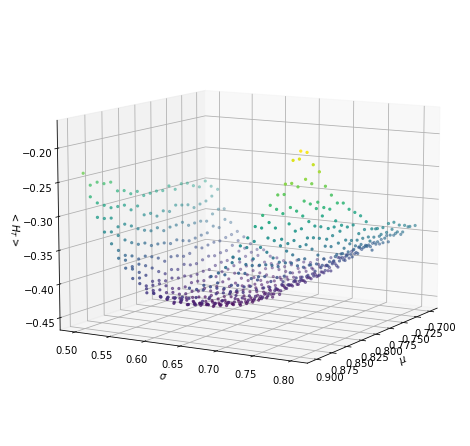

In [31]:
mu, sigma, H = np.loadtxt("ex8.1/variational.dat", usecols=(0,1,2), unpack = True)

fig = plt.figure(figsize = (9, 6))
ax = Axes3D(fig)
ax.scatter(mu, sigma, H, c=H, marker='.')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('$<H_T>$')
ax.view_init(10, 30)

print("<H> is minimized when mu =", mu[np.argsort(H)[0]], ", sigma =", sigma[np.argsort(H)[0]])

The same script selects the best values of $\mu$ and $\sigma$ and then launches a second, longer, simulation ($M=10^7$) to obtain the correct estimate of the ground state energy. As always we plot this estimate with the blocking method (using $N=100$ blocks). 

At this point we would like to have a reference value of the GS energy, directly obtained through Schroedinger, to compare it with the numerical results obtained with the variational method. Unfortunetely the Schroedinger equation has no analytical solution: the only possibility is to discretize the 3D space in a lattice of $N$ points and evaluate the wavefunction on this lattice. We can represent the wavefunction as a vector $\vec \Psi \in \mathbb{R}^N$, and, once we discretize the first and second derivatives that are present in the equation, we can rewrite it in the matricial form:
$$
\begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
= E
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
$$

To obtain the _discretized results_ we need to obtain the eigenvalues and eigenstates of this matrix (we report the calculation below). Unfortunately the expected energy obtained with variational methods is not compatible with the predicted energy from the theoretical analysis, as it is clear from the graph below. The reason behind this big gap is that the wavefunction obtained through VMC methods is only the best function in the family of our trial functions $\Psi_T^{\mu, \sigma}$. To improve our guess we should investigate more analytical forms for the wavefunction.

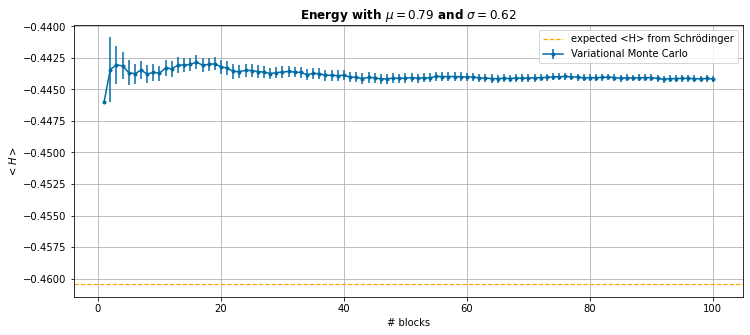

In [32]:
x, y, err = np.loadtxt('ex8.1/energy.dat', delimiter=" ", unpack=True)
Etrue = -0.46046587969271563

fig=plt.figure(figsize=(12, 5))
plt.title("Energy with $\mu=0.79$ and $\sigma=0.62$", weight='bold')
plt.errorbar(x, y, yerr=err, label='Variational Monte Carlo', marker='.')
plt.axhline(y=Etrue,linewidth=1.2,linestyle='--', color='orange',label='expected <H> from Schrödinger')
plt.ylabel('$<H>$')
plt.xlabel('# blocks')
plt.legend()
plt.grid(True)
plt.show()

Our final task was to plot the graph of $|\Psi_T(x)|^2$, that is, the probability density associated to our guess for the wavefunction of the ground state. To do so, we divided in $100$ bins the interval $x \in [-3,3]$ and from that we built an histogram recording the configurations sampled during the execution of the program.

In the following plot we show the theoretical predictions for the probability densities of the ground state and of the first two excited states from the matricial Schroedinger's equation; they will be a useful comparison with the plots generated in the following exercise. 

Finally we show a plot of the histogram we obtained from the variational simulation, and we compare it with the analytical prediction, that is, the normalized wavefunction $\Psi_T^{\mu, \sigma}$ where the optimal parameters are selected, and with the solution of the discretized Schroedinger's equation. 

The same discussion as for the energy applies here.


Ground state energy:  -0.46045845079911835
1st excited state energy:  0.09744706661807169
2nd excited state energy:  1.9718077373830059


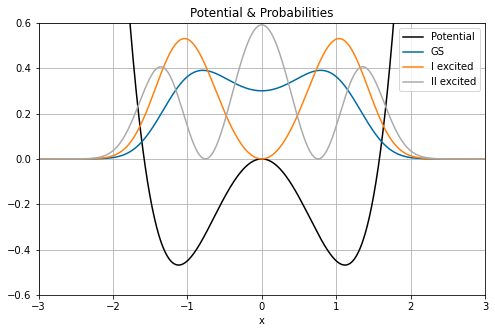

In [57]:
MU=0.79
SIGMA=0.62
def Vpot(x): return (x**2 - 2.5)*x**2

def p(x, MU, SIGMA):
    return (np.exp(-(x-MU)**2/(2*(SIGMA)**2)) + np.exp(-(x+MU)**2/(2*(SIGMA)**2)))**2
norm = quad(p, -3, 3, args=(MU,SIGMA))[0]

N = 1000 # number of iterations
hbar = 1
m = 1

x = np.linspace(-3, 3, 1000)
dx = x[1] - x[0] # the step size
V = Vpot(x)

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)
E,ps = np.linalg.eigh(H)
ps = np.transpose(ps)
ps = ps/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

# Plot a few things
plt.figure(figsize=(8,5))
scale = 0.3
plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(ps[0])**2, label='GS')
plt.plot(x,(ps[1])**2, label='I excited')
plt.plot(x,(ps[2])**2, label='II excited')
plt.title("Potential & Probabilities")
plt.legend()
plt.xlabel("x")
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
plt.show()

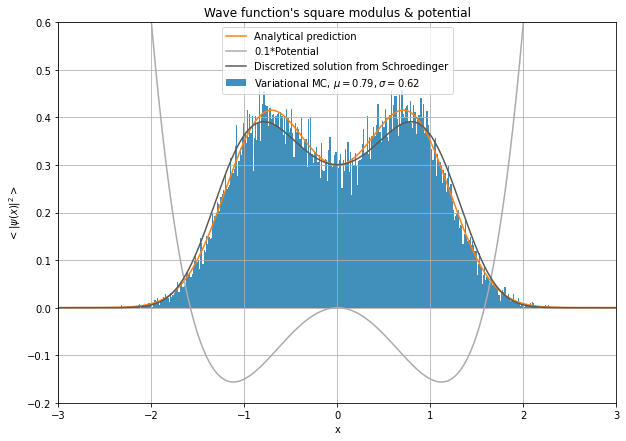

In [58]:
psi= np.loadtxt("ex8.1/psi2.dat",)
plt.figure(figsize=(10,7))
x=np.linspace(-3,3,1000)
plt.hist(psi, 400, density=True, alpha=0.75, label="Variational MC, $\mu=0.79, \sigma=0.62$")
#plt.plot(x_lin,psi_teo[0]**2, label="Analytic")
plt.plot(x,p(x, MU, SIGMA)/norm, label="Analytical prediction")
plt.plot(x, 0.1*Vpot(x), label='0.1*Potential')
plt.plot(x, ps[0]**2, label='Discretized solution from Schroedinger')
plt.legend()
plt.ylim(-0.2, 0.6)
plt.xlim(-3,3)
plt.grid(True)
plt.xlabel("x")
plt.title("Wave function's square modulus & potential")
plt.ylabel("$< |\psi(x)|^2 >$" )

plt.show()

## Exercise 08.3: PIGS & PIMC algorithms
__________________________

### The path integral approach

Feynman's idea of mapping with path integrals a quantum system onto a classical model of special interacting ring polymers provides a powerful computational tool to compute the ground state of a system at $T=0$ (Path Integral Ground State, PIGS) and at finite temperature $T>0$ (Path Integral Monte Carlo, PIMC). 

At zero temperature we can exploit _exact_ quantum Monte Carlo method to compure the exact ground state wavefunction: it will still be an approximation, but so accurate that the calculation of the expectation value of this state with Monte Carlo methods will differ from the exact value (unknown) by a quantity smaller than the statistical error of the calculation. In general, with the formalism of Green's functions:
$$
\psi(\vec r, t) = \int d^3r' \langle \vec r | e^{-it \hat H /\hbar}| \vec r' \rangle \langle \vec r'| \psi(0) \rangle = \int d^3 r' G(\vec r, \vec r', t) \psi(\vec r', 0).
$$
We can perform a Wick's rotation $t \to \tau = i t / \hbar$, therefore writing the propagator, and consequently the wavefunction, in terms of the imaginary time $\tau$. It is clear that the action of a Wick's roation, for large values of the imaginary time, will be to suppress the contribute of all the excited eigenstates:
$$
| \psi(\tau) \rangle = e^{-\tau \hat H} |\psi(0) \rangle 
= e^{-\tau \hat H} \sum_n c_n |\psi_n \rangle = \sum_n c_n e^{-\tau  E_n} |\psi_n \rangle \sim_{\tau >> 1} e^{-\tau E_0} |\psi_0 \rangle.
$$
Basically the imaginary time evolution projects the trial quantum state onto the ground state: projector Monte Carlo methods, where the propagator $G(\vec r, \vec r', \tau)$ (a density matrix) is approximated as well thanks to Lie Trotter decomposition and primitive approximation. We divide the time interval in $M$ timeslices, and, for big enough $M$ the system will be isometric to a classical system of polymers, that we can sample using Metropolis.

At finite temperature the idea is more or less the same, but the initial state will be described by a statistical mixture, so that the average of the  observable $\hat O$ will be:
$$
\langle \hat O \rangle = Tr(\hat \rho \hat O) = \frac{\int d^3 r \rho(\vec r, \vec r, \beta) O(\vec r)}{Tr(\hat \rho)}
$$
In this case the Trotter decomposition is used on the density matrix $\rho(\vec r, \vec r, \beta)= \langle \vec r|e^{-\beta \hat H}|\vec r\rangle$, and, using high $M$ following the primitive approximation in: $e^{-\tau \hat H} = (e^{-\tau/M \hat H})^M$, we recover the thermal expectation value that can be computed with MC integration.


### The results for the PIGS energy value

The code was provided and ready to use for the purposes of this exercise. The only modification we had to make was to add the possibility of starting from a non constant wavefunction (the default choiche of the code we were given, **constant trial**). In particular, we chose to start from the optimal parameters trial wavefunction of the previous exercise $\Psi_T^{\mu, \sigma}$ (**variational trial**). The constant trial needs more time to reach stable values of energy because the wavefunction is very far from the correct one. The variational trial should be already close to the correct form of the wavefunction.

In the next plot we show the PIGS results obtained for the ground state energy in both cases. We find that they are compatible with the expected values from the discretized Schroedinger method and from the variational trial. The energy should stay constant during the simulation, as the hamiltonian is time independent.

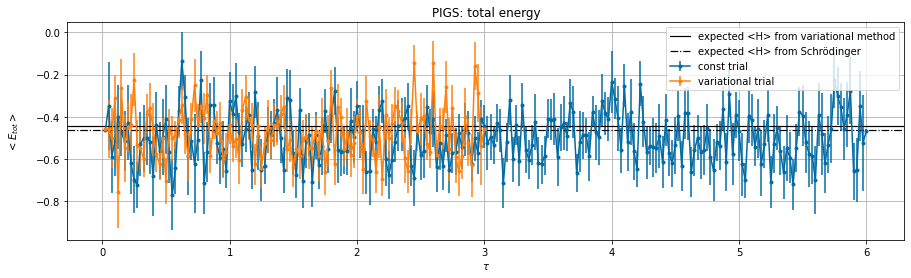

In [59]:
PIGS=[0 for i in range(4)]; obs=['potential','kinetic']; tau=['const_t6','var_t3']; tt=(6,3); tslice=(240,120)
for i in range(2):
    for j in range(2):
        PIGS[2*i+j]=np.genfromtxt('ex8.3/results/'+obs[i]+'.'+tau[j]+'.dat',names='time,res,err')
        
trial_type=("const trial","variational trial")
ene,err=[0,0],[0,0]
for i in range(2):
    ene[i]=PIGS[i]['res']+PIGS[i+2]['res']
    err[i]=np.sqrt(PIGS[i]['err']**2+PIGS[i+2]['err']**2)
    
fig,ax=plt.subplots(figsize=(15,4))
for i in range(2): plt.errorbar((PIGS[i]['time']+1)/tslice[i]*tt[i],ene[i],yerr=err[i],marker='.',label=trial_type[i])
plt.axhline(y=-0.444175,color='k',linewidth=1.2,label='expected <H> from variational method')
plt.axhline(y=E[0],color='k',linewidth=1.2,linestyle='-.',label='expected <H> from Schrödinger')
plt.legend(loc='best')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$<E_{tot}>$',labelpad=15)
plt.grid(True)
plt.title("PIGS: total energy")
plt.show()

### The results for the PIGS potential energy

Now let's take a look at the potential energy measured values in both the constant and variational trial. As we said, in the constant trial we need to let the wavefunction evolve for a longer time before it reaches the correct sampling. We can see a sort of _symmetry_ in the potential profile: towards the first and last timeslices the value of the potential energy increases quite dramatically. This is due to the Periodic Boundary Conditions internal to the algorithm: the open polymer to which the system is mapped in PIGS is closed with PBC on time evolution. In the central region though, the value of the potential energy is fairly constant. We can reasonably consider the middle region as an accurate time interval for the sampling of our ground state wavefunction.

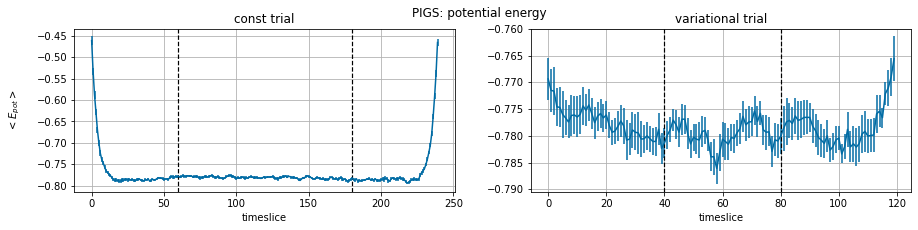

In [60]:
def img_evol(plot,howMany,xline,color):
    fig,ax=plt.subplots(figsize=(15,3))
    for i in range(2):
        plt.subplot(1,2,i+1)
        for j in range(howMany):
            plt.errorbar(plot[i+2*j]['time'],plot[i+2*j]['res'],yerr=plot[i+2*j]['err'])
            for k in [2*i+4*j,2*i+4*j+1]: plt.axvline(x=xline[k],color=color[j],linewidth=1.2,linestyle='--')
        plt.xlabel(r'timeslice')
        if i==0: plt.ylabel('$<E_{pot}>$',labelpad=15)
        plt.grid(True)
        plt.title(trial_type[i])
    plt.suptitle("PIGS: potential energy")
    plt.show()
    
img_evol(PIGS,1,(60,180,40,80),'k')

### PIGS wavefunction sampling  

We now show the samplings produced with diffent times of evolution $\tau$, by starting both by the constant and variational trial wavefunction. Again, the evolution time needed by the variational trial is smaller.

When selecting the timeslices to be used for the sampling of the wavefunction (can be declared in the input file of the program), we take care of considering times for which the value of the potential energy is fairly stable: in the following graph we can see how the choices we made seem to be reasonable. In particular:
- for $\tau = 1$ we select the timeslices in $[15, 25]$;
- for $\tau = 2$ we select the timeslices in $[30, 50]$;
- for $\tau = 3$ we select the timeslices in $[40, 80]$;
- for $\tau = 5$ we select the timeslices in $[50, 150]$.

The samplings are in accordance to the matrix equation theoretical result. The final plots represent the probability density of finding the particle at a certain $x$ point, when in the ground state energy level.

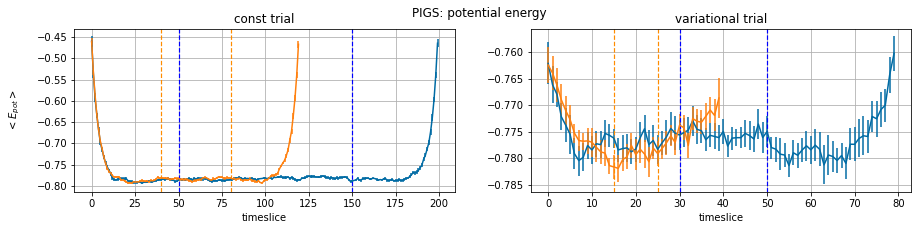

In [66]:
newPIGS=[0 for i in range(4)]
psiT=['const','var']*2
tau=['5','2','3','1']
for i in range(len(newPIGS)):
        newPIGS[i]=np.genfromtxt('ex8.3/results/potential.'+psiT[i]+'_t'+tau[i]+'.dat',names='time,res,err')
        
img_evol(newPIGS,2,(50,150,30,50,40,80,15,25),('b','darkorange'))

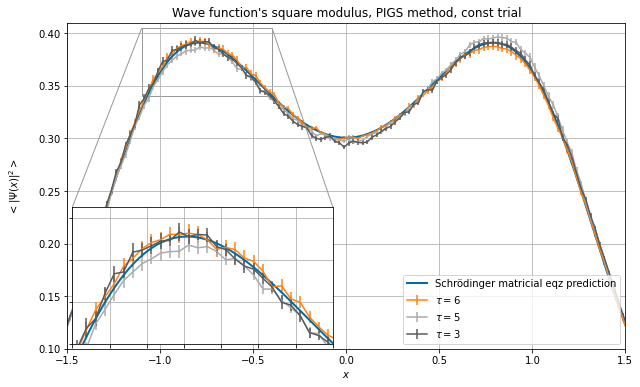

In [61]:
def wave_function(irg,plot,mark,lab,ifpot,xrg,yrg,title):
    plt.plot(x,(ps[0])**2,linewidth=2,label='Schrödinger matricial eqz prediction')
    for i in irg: plt.errorbar(plot[i]['nbin'],plot[i]['res'],yerr=plot[i]['err'],marker=mark[i],label=lab[i])
    if ifpot: plt.plot(psi[0]['nbin'],0.1*Vpot(psi[0]['nbin']),color="Black", label="0.1*Potential")
    plt.legend(loc=4)
    plt.xlabel('$x$')
    plt.ylabel('$<|\Psi(x)|^2>$',labelpad=15)
    plt.xlim(xrg)
    plt.ylim(yrg)
    plt.grid(True)
    plt.title(title)

def zoom(factor,irg,plot,mark,ifpot,xrg,yrg):
    axins=zoomed_inset_axes(ax,factor,loc=3)   # zoomed part, zoom and position
    axins.plot(x,(ps[0])**2,linewidth=2)
    for i in irg: plt.errorbar(plot[i]['nbin'],plot[i]['res'],yerr=plot[i]['err'],marker=mark[i])
    if ifpot: axins.plot(psi[0]['nbin'],0.1*Vpot(psi[0]['nbin']),color="Black")
    axins.set_xlim(xrg)
    axins.set_ylim(yrg)
    plt.grid(True)
    plt.yticks(visible=False)
    plt.xticks(visible=False)
    mark_inset(ax,axins,loc1=2,loc2=1,fc='none',ec='0.6')

psiPIGS=[0 for i in range(7)]
psiT=['const' for i in range(3)]+['var' for i in range(4)]
tau=['6','5','3','3','2','1','05']
for i in range(len(psiPIGS)):
    psiPIGS[i]=np.genfromtxt('ex8.3/results/probability.'+psiT[i]+'_t'+tau[i]+'.dat',names='nbin,res,err')

lab=('const trial','variational trial')

tau=['6','5','3','3','2','1','05']
fig,ax=plt.subplots(figsize=(10,6)); mark=['' for i in range(3)]; irg=range(3)
wave_function(irg,psiPIGS,mark,[r'$\tau='+tau[i]+'$' for i in irg],False,(-1.5,1.5),(0.1,0.41),"Wave function's square modulus, PIGS method, const trial")
zoom(2,range(3),psiPIGS,mark,False,(-1.1,-0.4),(0.34,0.405))
plt.show()

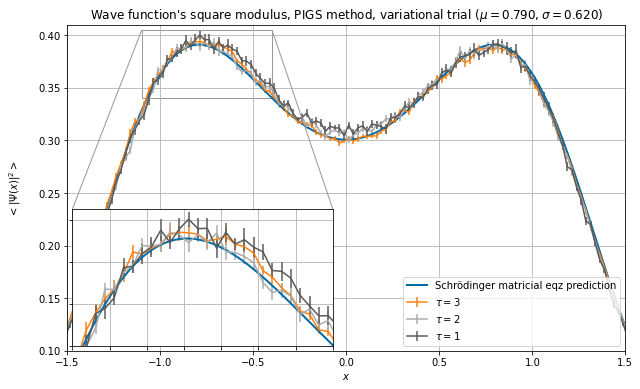

In [62]:
tau=['6','5','3','3','2','1','05']
fig,ax=plt.subplots(figsize=(10,6)); mark=['' for i in range(3)]; irg=range(3,6)
wave_function(irg,psiPIGS,mark*2,[r'$\tau='+tau[i]+'$' for i in range(6)],False,(-1.5,1.5),(0.1,0.41),"Wave function's square modulus, PIGS method, variational trial ($\mu="+format(MU,'.3f')+",\sigma="+format(SIGMA,'.3f')+"$)")
zoom(2,irg,psiPIGS,mark*2,False,(-1.1,-0.4),(0.34,0.405))
plt.show()

### PIMC samplings at finite temperature

We can finally try the PIMC code and see what happens at finite temperature. As we said, here we are approximating Boltzmann probability distribution. As the temperature increases we see how the function becomes smoother and smoother: the state is mixed up and basically its entropy is increasing to the point where each position is equiprobable. At lower temperature this is not the case: the probability of occupying the central region ($x \sim 0$) decreases for a while at increasing temperature, until a certain temperature (here we can see that at $T=5$ the probability density is already smoothing in the same region). 

A possible, very naive, explanation for this behavior is the fact that by increasing the temperature just a little bit we are giving enough energy to "fall" into one of the two symmetriacal low energy regions but not enough energy to escape from it.

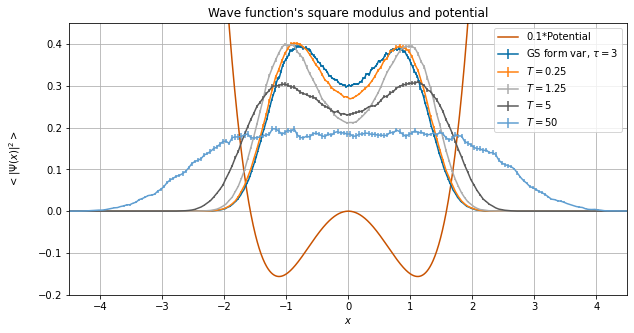

In [22]:
psiPIMC_0_25=np.genfromtxt('ex8.3/results/probability.T0_25.dat',names='nbin,res,err')
psiPIMC_1_25=np.genfromtxt('ex8.3/results/probability.T1_25.dat',names='nbin,res,err')
psiPIMC_5=np.genfromtxt('ex8.3/results/probability.T5.dat',names='nbin,res,err')
psiPIMC_50=np.genfromtxt('ex8.3/results/probability.T50.dat',names='nbin,res,err')
PIMC=(psiPIMC_0_25,psiPIMC_1_25,psiPIMC_5,psiPIMC_50)
x = np.linspace(-3, 3, 1000)

fig,ax=plt.subplots(figsize=(10,5)); label=('0.25','1.25','5','50')
plt.errorbar(psiPIGS[3]['nbin'],psiPIGS[3]['res'],yerr=psiPIGS[3]['err'],label=r'GS form var, $\tau=3$')
for i in range(4): plt.errorbar(PIMC[i]['nbin'],PIMC[i]['res'],yerr=PIMC[i]['err'],label=r'$T='+label[i]+'$')
plt.plot(x, 0.1*Vpot(x), label='0.1*Potential')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$<|\Psi(x)|^2>$',labelpad=15)
plt.xlim(-4.5,4.5)
plt.ylim(-0.2,0.45)
plt.grid(True)
plt.title("Wave function's square modulus and potential")
plt.show()